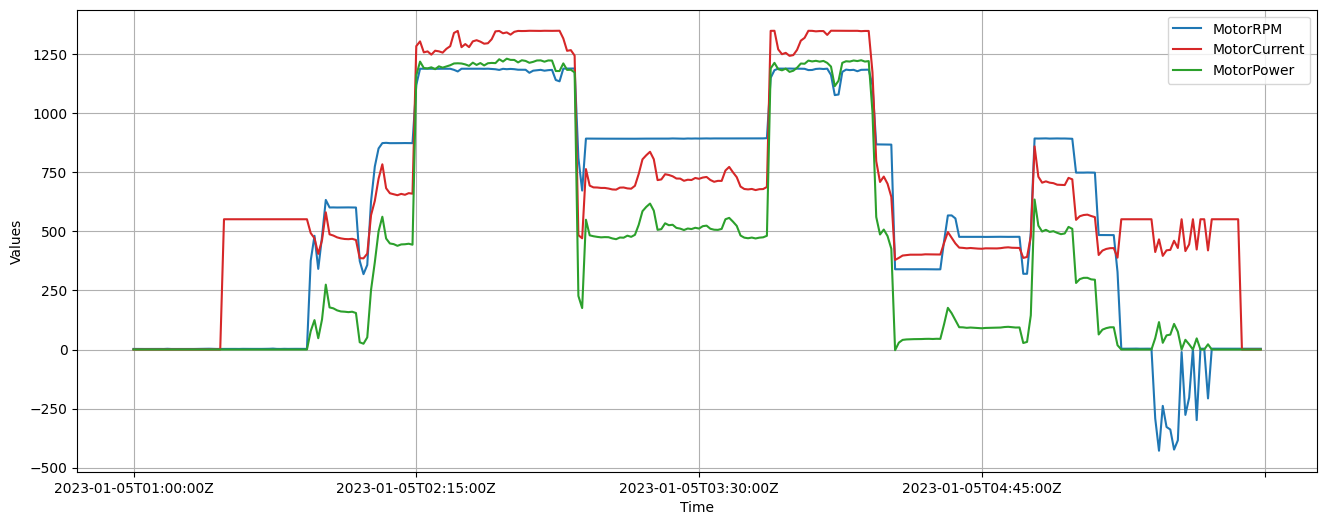

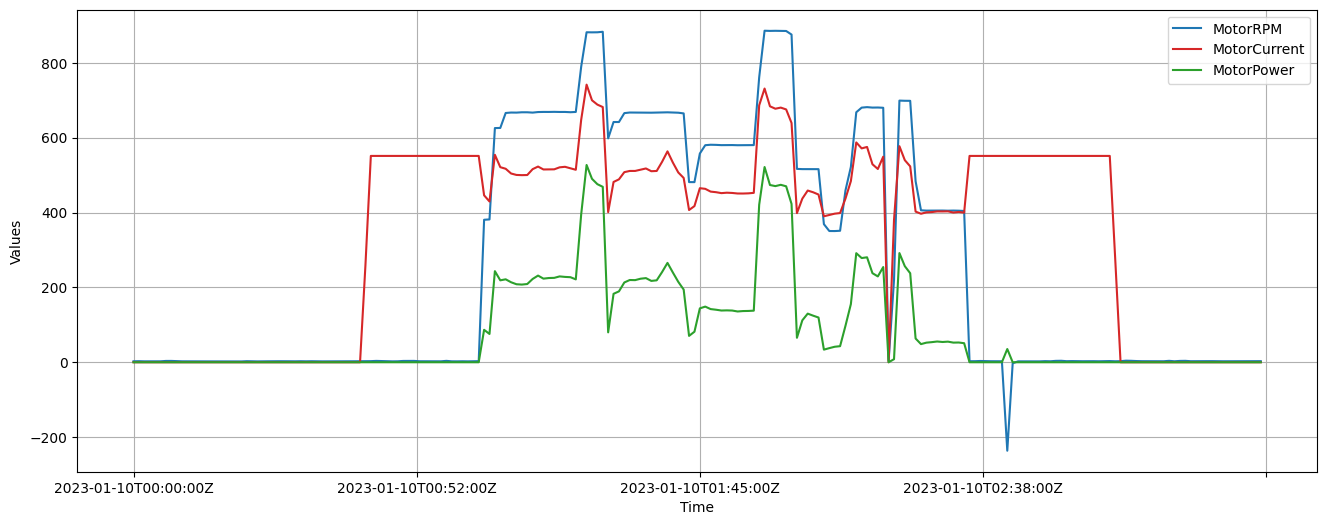

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from influxdb import InfluxDBClient
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.models import Model

# Connect to InfluxDB and fetch data
client = InfluxDBClient(host='localhost', port=8086)
client.switch_database('ISS')
query_train = 'SELECT * FROM "EP_Propulsion1.Thing_HMD8310" WHERE time >= \'2023-01-05T01:00:00Z\' AND time < \'2023-01-05T06:00:00Z\''
results = client.query(query_train)
df_train = pd.DataFrame.from_records(results.get_points())

query_test = 'SELECT * FROM "EP_Propulsion1.Thing_HMD8310" WHERE time >= \'2023-01-10T00:00:00Z\' AND time < \'2023-01-10T03:30:00Z\''
results = client.query(query_test)
df_test = pd.DataFrame.from_records(results.get_points())

# Convert MotorRPM, MotorCurrent, and MotorPower columns to numeric
df_train['MotorRPM'] = pd.to_numeric(df_train['MotorRPM'])
df_train['MotorCurrent'] = pd.to_numeric(df_train['MotorCurrent'])
df_train['MotorPower'] = pd.to_numeric(df_train['MotorPower'])

df_test['MotorRPM'] = pd.to_numeric(df_test['MotorRPM'])
df_test['MotorCurrent'] = pd.to_numeric(df_test['MotorCurrent'])
df_test['MotorPower'] = pd.to_numeric(df_test['MotorPower'])

# Set up the plot
fig, ax_train = plt.subplots(figsize=(16, 6))

# Plot MotorRPM as a line
ax_train.plot(df_train['time'], df_train['MotorRPM'], label='MotorRPM', color='tab:blue',  linestyle='-')

# Plot MotorCurrent as a line
ax_train.plot(df_train['time'], df_train['MotorCurrent'], label='MotorCurrent', color='tab:red', linestyle='-')

# Plot MotorPower as a line
ax_train.plot(df_train['time'], df_train['MotorPower'], label='MotorPower', color='tab:green', linestyle='-')

# Set x-axis ticks and grid
total_len = len(df_train.index)
ax_train.set_xticks(np.arange(0, total_len + 1, total_len / 4))
ax_train.grid(True)

# Set labels and legend
ax_train.set_xlabel('Time')
ax_train.set_ylabel('Values')
ax_train.legend()

# Set up the plot
fig, ax_test = plt.subplots(figsize=(16, 6))

# Plot MotorRPM as a line
ax_test.plot(df_test['time'], df_test['MotorRPM'], label='MotorRPM', color='tab:blue',  linestyle='-')

# Plot MotorCurrent as a line
ax_test.plot(df_test['time'], df_test['MotorCurrent'], label='MotorCurrent', color='tab:red', linestyle='-')

# Plot MotorPower as a line
ax_test.plot(df_test['time'], df_test['MotorPower'], label='MotorPower', color='tab:green', linestyle='-')

# Set x-axis ticks and grid
total_len = len(df_test.index)
ax_test.set_xticks(np.arange(0, total_len + 1, total_len / 4))
ax_test.grid(True)

# Set labels and legend
ax_test.set_xlabel('Time')
ax_test.set_ylabel('Values')
ax_test.legend()

# Show the plot
plt.show()




In [13]:
# Normalize the data (Min-Max scaling)
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(df_train[['MotorRPM', 'MotorCurrent', 'MotorPower']])
scaled_test_data = scaler.transform(df_test[['MotorRPM', 'MotorCurrent', 'MotorPower']])

# Define hyperparameters
sequence_length = 50  # Length of each sequence
num_features = 3     # Number of features (MotorRPM, MotorCurrent, MotorPower)
encoding_dim = 2      # Size of the encoding (compression) layer
epochs = 50           # Number of training epochs
batch_size = 32      # Batch size

# Prepare sequences of data for the LSTM
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i : i + sequence_length])
    return np.array(sequences)

# Create sequences for training and testing data
X_train = create_sequences(scaled_train_data, sequence_length)
X_test = create_sequences(scaled_test_data, sequence_length)

# Define the autoencoder architecture
input_layer = Input(shape=(sequence_length, num_features))
encoder = LSTM(encoding_dim, activation='relu')(input_layer)
decoder = RepeatVector(sequence_length)(encoder)
decoder = LSTM(num_features, activation='relu', return_sequences=True)(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, X_test))

# Make predictions on the test data
predictions = autoencoder.predict(X_test)


Epoch 1/50
8/8 [==============================] - 2s 57ms/step - loss: 0.3535 - val_loss: 0.1163
Epoch 2/50
8/8 [==============================] - 0s 21ms/step - loss: 0.3509 - val_loss: 0.1144
Epoch 3/50
8/8 [==============================] - 0s 23ms/step - loss: 0.3470 - val_loss: 0.1127
Epoch 4/50
8/8 [==============================] - 0s 22ms/step - loss: 0.3411 - val_loss: 0.1100
Epoch 5/50
8/8 [==============================] - 0s 21ms/step - loss: 0.3326 - val_loss: 0.1070
Epoch 6/50
8/8 [==============================] - 0s 21ms/step - loss: 0.3227 - val_loss: 0.1049
Epoch 7/50
8/8 [==============================] - 0s 20ms/step - loss: 0.3097 - val_loss: 0.1034
Epoch 8/50
8/8 [==============================] - 0s 22ms/step - loss: 0.2933 - val_loss: 0.1030
Epoch 9/50
8/8 [==============================] - 0s 20ms/step - loss: 0.2729 - val_loss: 0.1057
Epoch 10/50
8/8 [==============================] - 0s 21ms/step - loss: 0.2616 - val_loss: 0.1085
Epoch 11/50
8/8 [============

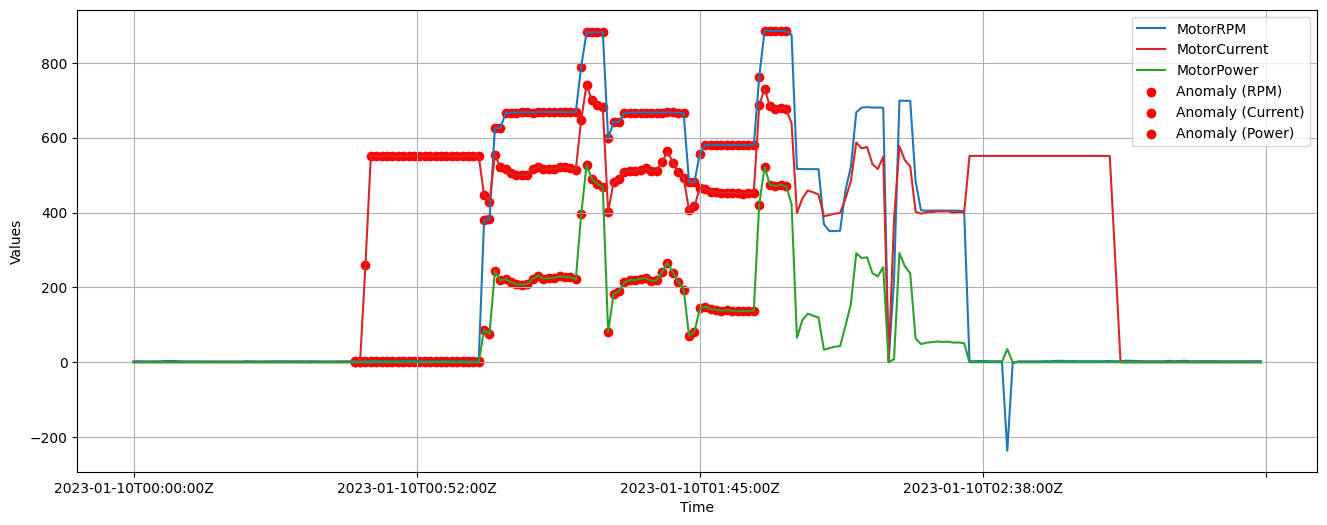

In [15]:
# Calculate the reconstruction error (MSE)
mse = np.mean(np.square(X_test - predictions), axis=(1, 2))

# Define a threshold for anomaly detection (you can experiment with different thresholds)
threshold = 0.1

# Identify anomalies based on the threshold
anomalies = mse > threshold

# Create a copy of the test data for plotting
df_test_copy = df_test.copy()

# Ensure that the length of anomalies matches the number of rows in df_test_copy
if len(anomalies) != len(df_test_copy):
    # Trim or pad the anomalies array to match the length of df_test_copy
    if len(anomalies) < len(df_test_copy):
        anomalies = np.concatenate([anomalies, np.zeros(len(df_test_copy) - len(anomalies), dtype=bool)])
    else:
        anomalies = anomalies[:len(df_test_copy)]

df_test_copy['Anomaly'] = anomalies  # Add a new column to mark anomalies

# Set up the plot
fig, ax_test = plt.subplots(figsize=(16, 6))

# Plot MotorRPM as a line
ax_test.plot(df_test_copy['time'], df_test_copy['MotorRPM'], label='MotorRPM', color='tab:blue', linestyle='-')

# Plot MotorCurrent as a line
ax_test.plot(df_test_copy['time'], df_test_copy['MotorCurrent'], label='MotorCurrent', color='tab:red', linestyle='-')

# Plot MotorPower as a line
ax_test.plot(df_test_copy['time'], df_test_copy['MotorPower'], label='MotorPower', color='tab:green', linestyle='-')

# Highlight anomalies
anomaly_points = df_test_copy[df_test_copy['Anomaly']]['time']
ax_test.scatter(anomaly_points, df_test_copy[df_test_copy['Anomaly']]['MotorRPM'], marker='o', color='red', label='Anomaly (RPM)')
ax_test.scatter(anomaly_points, df_test_copy[df_test_copy['Anomaly']]['MotorCurrent'], marker='o', color='red', label='Anomaly (Current)')
ax_test.scatter(anomaly_points, df_test_copy[df_test_copy['Anomaly']]['MotorPower'], marker='o', color='red', label='Anomaly (Power)')

# Set x-axis ticks and grid
total_len = len(df_test.index)
ax_test.set_xticks(np.arange(0, total_len + 1, total_len / 4))
ax_test.grid(True)

# Set labels and legend
ax_test.set_xlabel('Time')
ax_test.set_ylabel('Values')
ax_test.legend()

# Show the plot
plt.show()